In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input



In [2]:
from pathlib import Path
train_dir = Path(r'C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\train')
train_filepaths = list(train_dir.glob('**/*.jpg'))

In [3]:
test_dir = Path(r'C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
val_dir = Path(r'C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
from pathlib import Path
import pandas as pd

def image_processing(filepaths):
    """
    Create a DataFrame with the filepaths and the labels of the pictures.
    """
    # Extract labels from the file paths
    labels = [Path(filepath).parent.name for filepath in filepaths]

    # Create a DataFrame
    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    label_series = pd.Series(labels, name='Label')
    df = pd.concat([filepath_series, label_series], axis=1)

    # Shuffle the DataFrame and reset the index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [6]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3397

Number of different labels: 42

Labels: ['onion' 'tomato' 'carrot' 'Sunflower' 'peas' 'grapes' 'lemon' 'lettuce'
 'cabbage' 'pineapple' 'chilli pepper' 'bell pepper' 'soy beans' 'paprika'
 'Crimson Clover' 'eggplant' 'corn' 'kiwi' 'pear' 'beetroot' 'capsicum'
 'Daisy Fleabane' 'raddish' 'garlic' 'sweetcorn' 'turnip' 'pomegranate'
 'spinach' 'cucumber' 'mango' 'Milk Thistle' 'watermelon' 'Asparagus'
 'orange' 'jalepeno' 'potato' 'Fireweed' 'apple' 'cauliflower' 'banana'
 'ginger' 'sweetpotato']


In [8]:
train_df.head(5)

,Filepath,Label
0,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,onion
1,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,tomato
2,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,carrot
3,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,Sunflower
4,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,peas


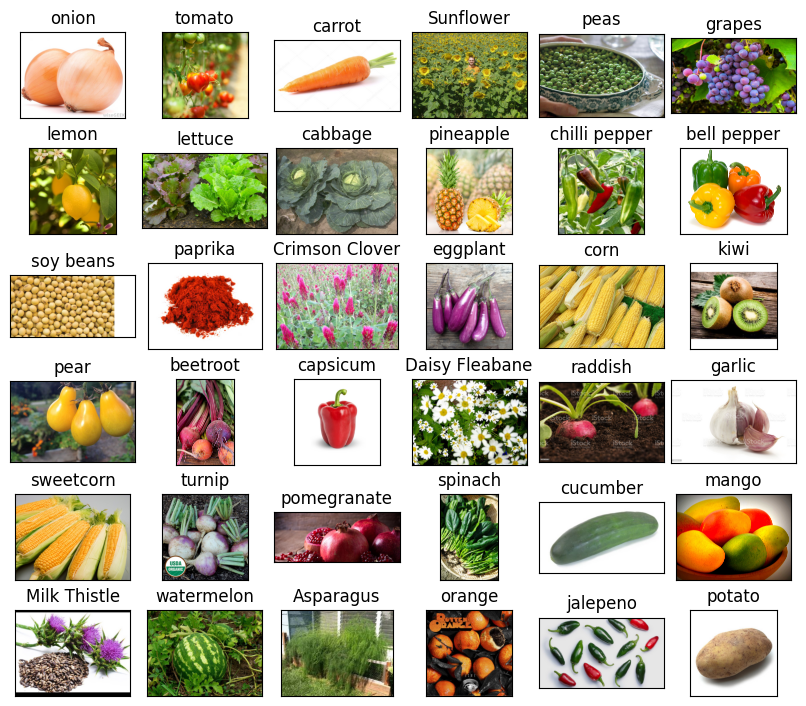

In [9]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3397 validated image filenames belonging to 42 classes.


In [12]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 430 validated image filenames belonging to 42 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 430 validated image filenames belonging to 42 classes.


In [14]:
pretrained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False


In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

c:\Users\ARIHANT\anaconda3\envs\new_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.3173 - loss: 2.6949 - val_accuracy: 0.8163 - val_loss: 0.6748
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7377 - loss: 0.8292 - val_accuracy: 0.8651 - val_loss: 0.4145
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8188 - loss: 0.5500 - val_accuracy: 0.8907 - val_loss: 0.3698
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8707 - loss: 0.3927 - val_accuracy: 0.9372 - val_loss: 0.2568
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9083 - loss: 0.2799 - val_accuracy: 0.9349 - val_loss: 0.2436
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9188 - loss: 0.2520 - val_accuracy: 0.9465 - val_loss: 0.1895
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9425 - loss: 0.1730 - val_accuracy: 0.9116 - val_loss: 0.2527
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9343 - loss: 0.1961 - val_accu

In [16]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('model2.h5')
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
labels = train_images.class_indices
labels = dict((v, k) for k, v in labels.items())
pred1 = []

for index in pred:
    if index in labels:  
        pred1.append((index, labels[index]))
    else:
        pred1.append((index, "Unknown"))  

for index, label in pred1:
    print(f"Predicted Index: {index}, Predicted Label: {label}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 917ms/step
Predicted Index: 20, Predicted Label: grapes
Predicted Index: 38, Predicted Label: sweetpotato
Predicted Index: 5, Predicted Label: Sunflower
Predicted Index: 23, Predicted Label: lemon
Predicted Index: 24, Predicted Label: lettuce
Predicted Index: 18, Predicted Label: garlic
Predicted Index: 17, Predicted Label: eggplant
Predicted Index: 0, Predicted Label: Asparagus
Predicted Index: 3, Predicted Label: Fireweed
Predicted Index: 34, Predicted Label: raddish
Predicted Index: 9, Predicted Label: bell pepper
Predicted Index: 21, Predicted Label: jalepeno
Predicted Index: 35, Predicted Label: soy beans
Predicted Index: 0, Predicted Label: Asparagus
Predicted Index: 15, Predicted Label: corn
Predicted Index: 20, Predicted Label: grapes
Predicted Index: 16, Predicted Label: cucumber
Predicted Index: 10, Predicted Label: cabbage
Predicted Index: 2, Predicted Label: Daisy Fleabane
Predicted Index: 5, Predicted Label: Sunflower
Predicted Index: 5, Pred

In [17]:
from tensorflow.keras.utils import load_img, img_to_array
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

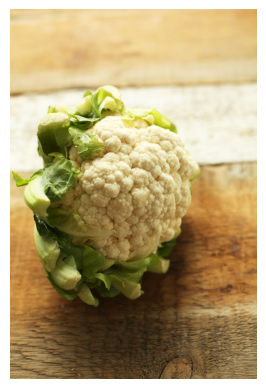

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'cauliflower'

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = r"C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\train\cauliflower\Image_1.jpg"
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

img = output(r"C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\train\cauliflower\Image_1.jpg")
img

In [19]:
model.save('model2.h5')

In [20]:
print(train_images.class_indices)

{'Asparagus': 0, 'Crimson Clover': 1, 'Daisy Fleabane': 2, 'Fireweed': 3, 'Milk Thistle': 4, 'Sunflower': 5, 'apple': 6, 'banana': 7, 'beetroot': 8, 'bell pepper': 9, 'cabbage': 10, 'capsicum': 11, 'carrot': 12, 'cauliflower': 13, 'chilli pepper': 14, 'corn': 15, 'cucumber': 16, 'eggplant': 17, 'garlic': 18, 'ginger': 19, 'grapes': 20, 'jalepeno': 21, 'kiwi': 22, 'lemon': 23, 'lettuce': 24, 'mango': 25, 'onion': 26, 'orange': 27, 'paprika': 28, 'pear': 29, 'peas': 30, 'pineapple': 31, 'pomegranate': 32, 'potato': 33, 'raddish': 34, 'soy beans': 35, 'spinach': 36, 'sweetcorn': 37, 'sweetpotato': 38, 'tomato': 39, 'turnip': 40, 'watermelon': 41}


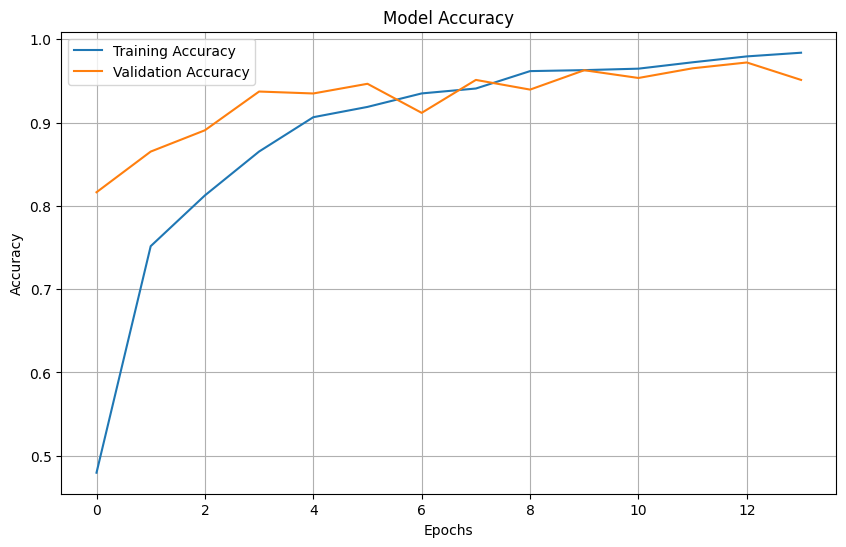

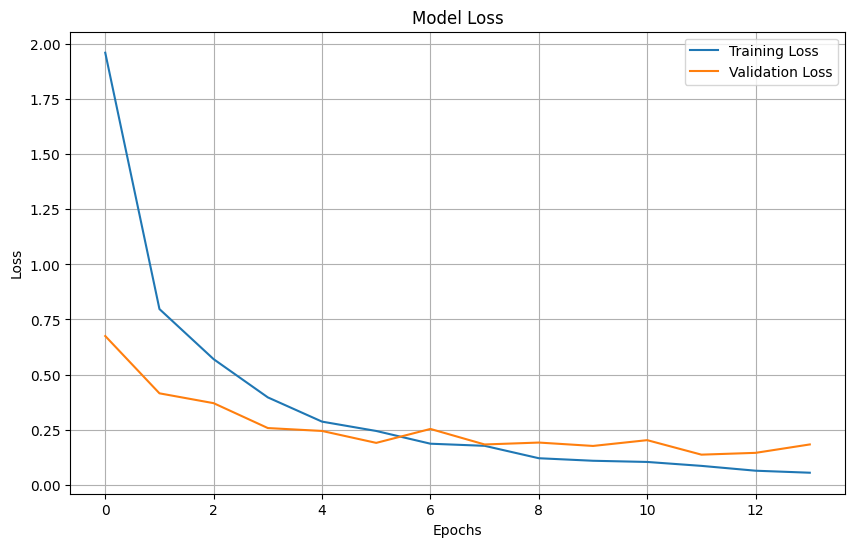

In [21]:
# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [22]:
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 879ms/step


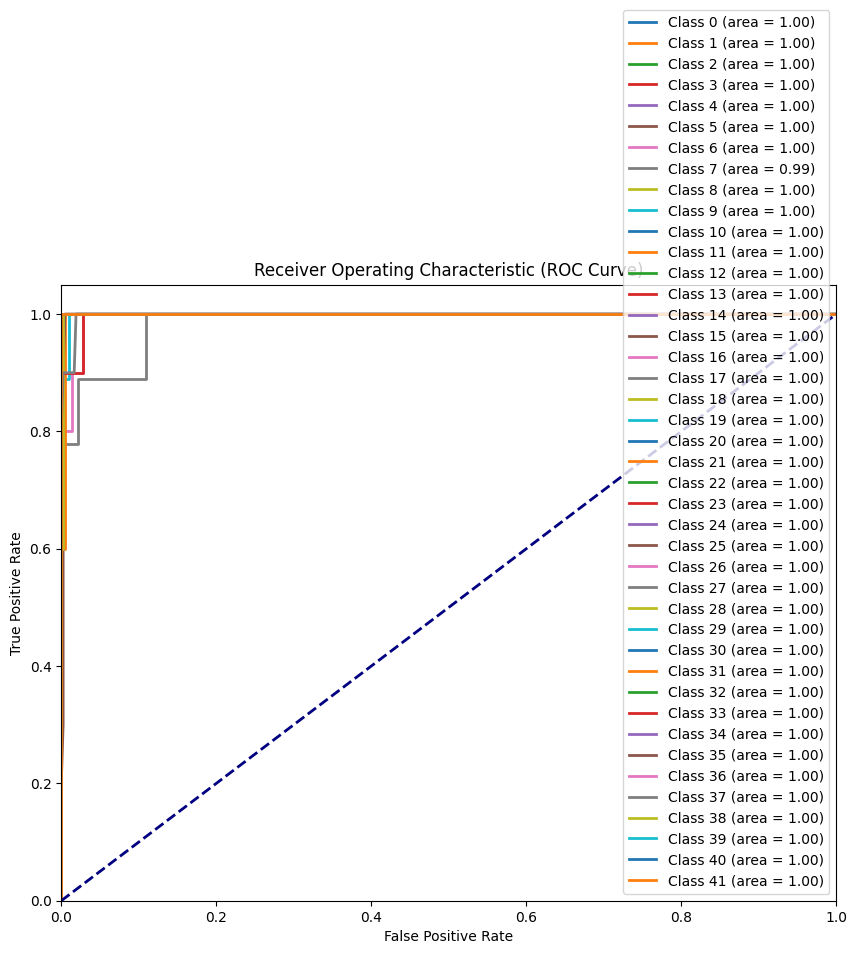

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict the probabilities
y_pred_prob = model.predict(test_images)

# Get the true labels for the test set
y_true = test_images.classes

# Binarize the true labels for multi-class classification
y_true_bin = label_binarize(y_true, classes=[i for i in range(len(train_images.class_indices))])

# Initialize a plot for ROC curve
plt.figure(figsize=(10, 8))

# Plot the ROC curve for each class
for i in range(len(train_images.class_indices)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot the diagonal (random classifier) line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc='lower right')

# Display the plot
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 855ms/step


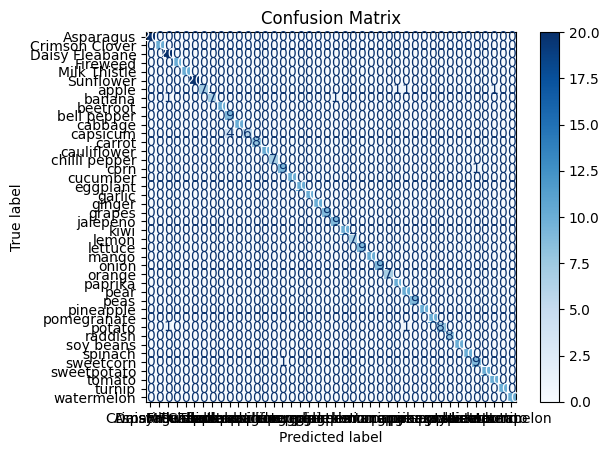

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions
true_labels = test_images.classes
predictions = np.argmax(model.predict(test_images), axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_images.class_indices.keys())

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predictions, target_names=test_images.class_indices.keys())
print(report)


                precision    recall  f1-score   support

     Asparagus       1.00      1.00      1.00        20
Crimson Clover       1.00      1.00      1.00        10
Daisy Fleabane       0.91      1.00      0.95        20
      Fireweed       1.00      1.00      1.00        10
  Milk Thistle       1.00      1.00      1.00        10
     Sunflower       1.00      1.00      1.00        20
         apple       1.00      0.70      0.82        10
        banana       1.00      0.78      0.88         9
      beetroot       1.00      1.00      1.00        10
   bell pepper       0.69      1.00      0.82         9
       cabbage       1.00      1.00      1.00        10
      capsicum       1.00      0.60      0.75        10
        carrot       1.00      1.00      1.00         8
   cauliflower       1.00      1.00      1.00        10
 chilli pepper       1.00      1.00      1.00         7
          corn       0.90      0.90      0.90        10
      cucumber       1.00      1.00      1.00  

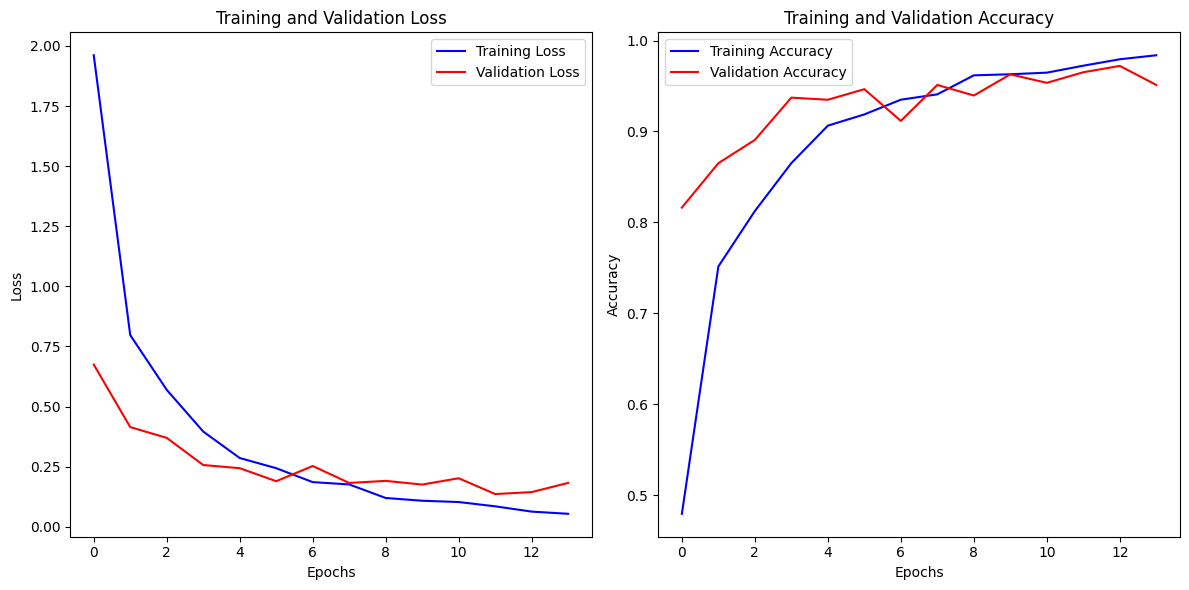

In [26]:
import matplotlib.pyplot as plt

# Training and validation loss
plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 845ms/step


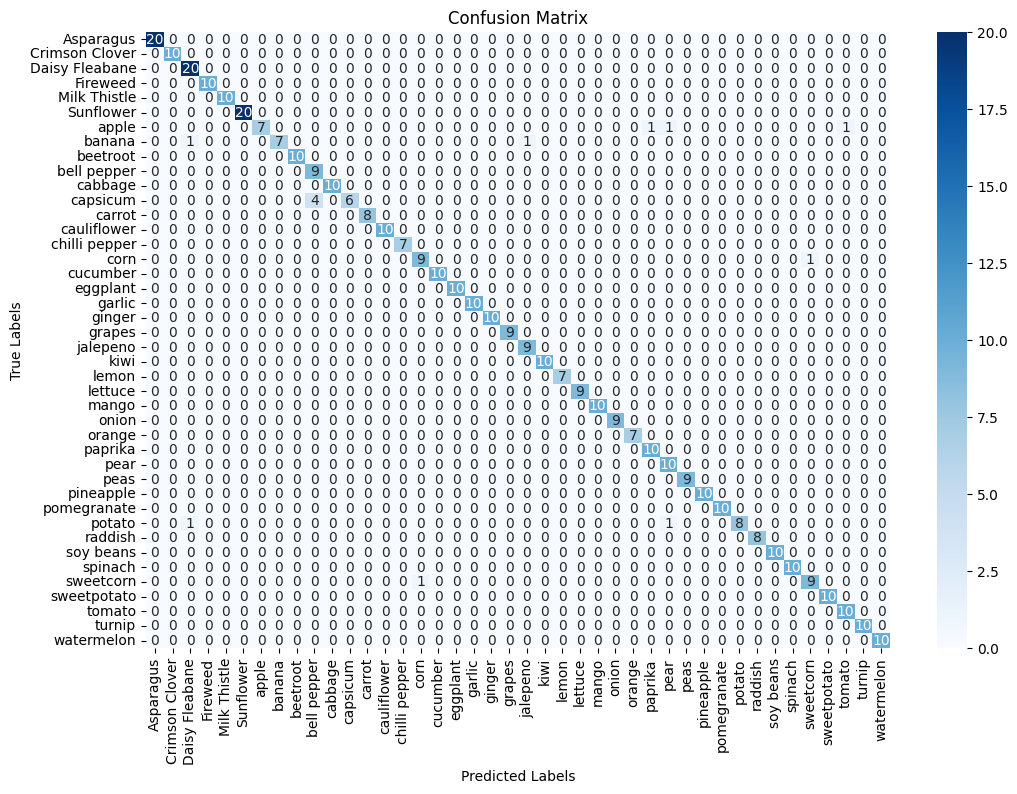

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels for the test dataset
true_labels = test_images.classes

# Get predictions from the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class labels
class_labels = list(train_images.class_indices.keys())

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [30]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='MobileNetV2 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='MobileNetV2 Validation Accuracy')
plt.plot(history2.history['accuracy'], label='InceptionV3 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='InceptionV3 Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='MobileNetV2 Train Loss')
plt.plot(history.history['val_loss'], label='MobileNetV2 Validation Loss')
plt.plot(history2.history['loss'], label='InceptionV3 Train Loss')
plt.plot(history2.history['val_loss'], label='InceptionV3 Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


<Figure size 1000x1000 with 0 Axes>

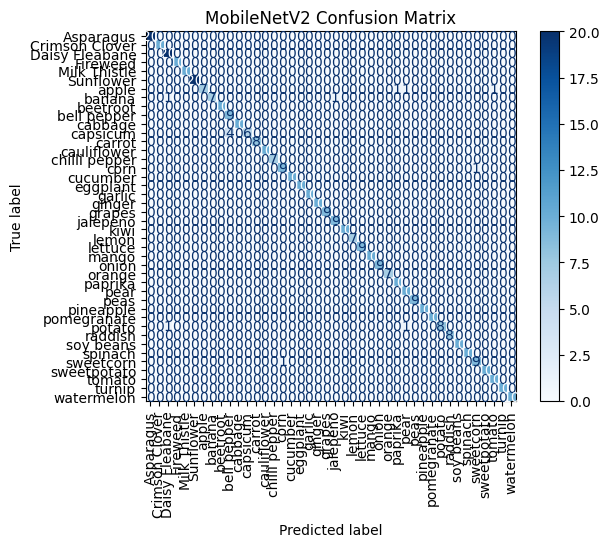

<Figure size 1000x1000 with 0 Axes>

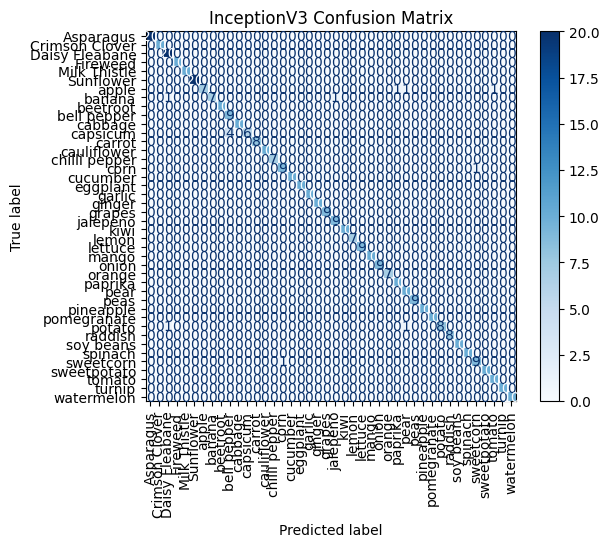

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# MobileNetV2 Confusion Matrix
true_labels = test_images.classes
mobilenet_predictions = np.argmax(model.predict(test_images), axis=1)
mobilenet_cm = confusion_matrix(true_labels, mobilenet_predictions)

# InceptionV3 Confusion Matrix
inception_predictions = np.argmax(model.predict(test_images), axis=1)
inception_cm = confusion_matrix(true_labels, inception_predictions)

# Plot Confusion Matrix for MobileNetV2
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=mobilenet_cm, display_labels=list(labels.values()))
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.title('MobileNetV2 Confusion Matrix')
plt.show()

# Plot Confusion Matrix for InceptionV3
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=inception_cm, display_labels=list(labels.values()))
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.title('InceptionV3 Confusion Matrix')
plt.show()
